In [ ]:
from time import time
import os
import math
import numpy as np
import pandas as pd

from keras.models import Model, Input, load_model #model_from_json
from keras.layers import Masking, Flatten, Embedding, Dense, LSTM, TimeDistributed
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras import regularizers
from keras import optimizers

from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, classification_report
from sklearn.metrics import recall_score, precision_score
from sklearn.model_selection import StratifiedKFold

In [ ]:
def PadSequences(df, lb, time_steps, pad_value=-100):
    ''' Takes a file path for the dataframe to operate on.  
        ub is an upper bound to truncate on. All entries are padded to their ubber bound '''
    df = df.groupby('stay_key').apply(lambda group: group[-time_steps:] if len(group) > time_steps else group).reset_index(drop=True)
    df = df.groupby('stay_key').apply(lambda group: pd.concat([group, pd.DataFrame(pad_value*np.ones((time_steps-len(group), len(df.columns))), columns=df.columns)], axis=0)).reset_index(drop=True)
    return df

def ZScoreNormalize(matrix):
    ''' Performs Z Score Normalization for 3rd order tensors 
        matrix should be (batchsize, time_steps, features) 
        Padded time steps should be masked with np.nan '''
    x_matrix = matrix[:,:,0:-1]
    y_matrix = matrix[:,:,-1]
    y_matrix = y_matrix.reshape(y_matrix.shape[0],y_matrix.shape[1],1)
    means = np.nanmean(x_matrix, axis=(0,1))
    stds = np.nanstd(x_matrix, axis=(0,1))
    x_matrix = x_matrix-means
    x_matrix = x_matrix / stds
    matrix = np.concatenate([x_matrix, y_matrix], axis=2)
    return matrix

In [ ]:
# folder for tmp files
tmp_output_dir = "./mimic_tmp"

In [ ]:
# readin MIMIC-III data
df_data = pd.read_table("drive/MyDrive/time_series.csv", delimiter=",")

In [ ]:
cols = ['Time', 'stay_id', 'stay_key', 'hadm_id', 'age', 'gender', 'Heart Rate',
       'Respiratory Rate', 'SpO2/SaO2', 'pH', 'Potassium', 'Calcium',
       'Glucose', 'Sodium', 'HCO3', 'White Blood Cells', 'Hemoglobin',
       'Red Blood Cells', 'Platelet Count', 'Weight', 'Urea Nitrogen',
       'Creatinine', 'Blood Pressure', '1 hours urine output',
       '6 hours urine output', 'AKI', 'gcs',
       'ventilation', 'vasoactive medications', 'sedative medications']
df_data['stay_key'] = df_data['stay_id']
# Missing values imputation
df_filled = df_data.groupby('stay_id')[cols].ffill().bfill()

# AKI_hour: the time of AKI if the sample have AKI
df_filled['AKI_hour'] = df_filled.apply(lambda x: x['Time'] if x['AKI'] == 1 else 0, axis=1)

In [ ]:
# === option 1: use the next hour AKI as the current timepoint outcome via shift by ID
# df_filled['AKI_next'] = df_filled.groupby('stay_key')['AKI'].shift(-1)

In [ ]:
# === option 2: use the next 6 hours as the current timepoint outcome. Cut the timepoint after AKI accured

#=== keep the patients if time_steps > 6
df_filled = df_filled.groupby('stay_key').filter(lambda group: len(group) > 6).reset_index(drop=True)
AKI_time = df_filled[df_filled['AKI'] == 1].groupby('stay_key')['AKI_hour'].first()
df_new = pd.merge(df_filled, AKI_time, left_on=['stay_key'], right_index=True, how='left').drop('AKI_hour_x', axis=1).rename({'AKI_hour_y': 'AKI_time'}, axis=1)
df_new['time_to_AKI'] = (pd.to_datetime(df_new['AKI_time']) - pd.to_datetime(df_new['Time'])) / np.timedelta64(1, 'h')
#=== remove the last 6 time steps of each patient
df_new = df_new.groupby('stay_key').apply(lambda group: group[:-6]).reset_index(drop=True)
#=== only keep the time_step before the first AKI
df_new = df_new[~(df_new['time_to_AKI'] <= 0)]
#=== if time_to_AKI < 6, outcome = 1
df_new['AKI_next'] = df_new.apply(lambda x: 1 if x['time_to_AKI'] < 6 else 0, axis=1)

(2448522, 29)
count    33964.000000
mean        72.091685
std         86.011604
min          1.000000
50%         43.000000
80%        100.000000
85%        123.000000
90%        162.000000
max        709.000000
Name: Time, dtype: float64


Text(0, 0.5, 'Counts')

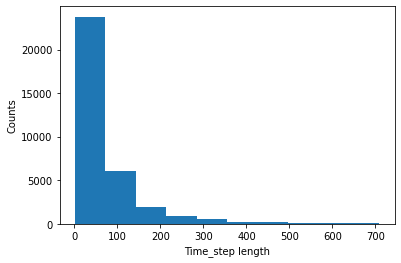

In [ ]:
#=== plot the time steps
print(df_new.shape)
time_steps_count = df_new.groupby('stay_key')['Time'].count()
print(time_steps_count.describe(percentiles=[0.8,0.85,0.9]))
import matplotlib.pyplot as plt
plt.hist(time_steps_count)
plt.xlabel("Time_step length")
plt.ylabel("Counts")
#take 100 >80% as the time_stemps

In [ ]:
df_new = df_new.drop(['AKI','AKI_time','time_to_AKI'],axis=1).reset_index(drop=True)
time_steps =100

In [ ]:
from keras.layers.core import Dense, Reshape, Lambda, RepeatVector, Permute, Flatten
from keras.layers import multiply
def attention_3d_block(inputs, TIME_STEPS):
    """
    inputs.shape = (batch_size, time_steps, input_dim)
    """ 
    input_dim = int(inputs.shape[2])
    a = Permute((2, 1))(inputs)
    a = Reshape((input_dim, TIME_STEPS))(a)
    a = Dense(TIME_STEPS, activation='softmax')(a)
    a_probs = Permute((2, 1), name='attention_vec')(a)
    output_attention_mul = multiply([inputs, a_probs])
    return output_attention_mul

In [ ]:
def return_data(balancer=True, target='AKI_next',return_cols=False, 
         tt_split=0.7, val_percentage=0.8, cross_val=False,
         mask=False, time_steps=14, split=True, pad=True):
  """
  Returns synthetic or real data depending on parameter
  Args:
  -----
      balance : whether or not to balance positive and negative time windows
      return_cols : return columns used for this RNN
      tt_split : fraction of dataset to use fro training, remaining is used for test
      cross_val : parameter that returns entire matrix unsplit and unbalanced for cross val purposes
      mask : 24 hour mask, default is False
      dataframe : returns dataframe rather than numpy ndarray
      time_steps : 14 by default, required for padding
      split : creates test train splits
      pad : by default is True, will pad to the time_step value
  Returns:
  -------
      Training and validation splits as well as the number of columns for use in RNN
  """

  df = df_new.select_dtypes(exclude=['object'])

  if pad:
    pad_value=0
    df = PadSequences(df, 0, time_steps, pad_value=pad_value)
    print('There are {0} rows in the df after padding'.format(len(df)))

  COLUMNS = list(df.drop(['stay_key','hadm_id',target],axis =1).columns)
  if return_cols:
    return COLUMNS

  MATRIX = df[COLUMNS+[target]].values
  MATRIX = MATRIX.reshape(int(MATRIX.shape[0]/time_steps),time_steps,MATRIX.shape[1])

  ## note we are creating a second order bool matirx
  bool_matrix = (~MATRIX.any(axis=2))
  MATRIX[bool_matrix] = np.nan
  MATRIX = ZScoreNormalize(MATRIX)
  ## restore 3D shape to boolmatrix for consistency
  bool_matrix = np.isnan(MATRIX)
  MATRIX[bool_matrix] = pad_value

  permutation = np.random.permutation(MATRIX.shape[0])
  MATRIX = MATRIX[permutation]
  bool_matrix = bool_matrix[permutation]

  X_MATRIX = MATRIX[:,:,0:-1]
  Y_MATRIX = MATRIX[:,:,-1]

  x_bool_matrix = bool_matrix[:,:,0:-1]
  y_bool_matrix = bool_matrix[:,:,-1]

  X_TRAIN = X_MATRIX[0:int(tt_split*X_MATRIX.shape[0]),:,:]
  Y_TRAIN = Y_MATRIX[0:int(tt_split*Y_MATRIX.shape[0]),:]
  Y_TRAIN = Y_TRAIN.reshape(Y_TRAIN.shape[0], Y_TRAIN.shape[1], 1)

  X_VAL = X_MATRIX[int(tt_split*X_MATRIX.shape[0]):int(val_percentage*X_MATRIX.shape[0])]
  Y_VAL = Y_MATRIX[int(tt_split*Y_MATRIX.shape[0]):int(val_percentage*Y_MATRIX.shape[0])]
  Y_VAL = Y_VAL.reshape(Y_VAL.shape[0], Y_VAL.shape[1], 1)

  x_val_boolmat = x_bool_matrix[int(tt_split*x_bool_matrix.shape[0]):int(val_percentage*x_bool_matrix.shape[0])]
  y_val_boolmat = y_bool_matrix[int(tt_split*y_bool_matrix.shape[0]):int(val_percentage*y_bool_matrix.shape[0])]
  y_val_boolmat = y_val_boolmat.reshape(y_val_boolmat.shape[0],y_val_boolmat.shape[1],1)

  X_TEST = X_MATRIX[int(val_percentage*X_MATRIX.shape[0])::]
  Y_TEST = Y_MATRIX[int(val_percentage*X_MATRIX.shape[0])::]
  Y_TEST = Y_TEST.reshape(Y_TEST.shape[0], Y_TEST.shape[1], 1)

  x_test_boolmat = x_bool_matrix[int(val_percentage*x_bool_matrix.shape[0])::]
  y_test_boolmat = y_bool_matrix[int(val_percentage*y_bool_matrix.shape[0])::]
  y_test_boolmat = y_test_boolmat.reshape(y_test_boolmat.shape[0],y_test_boolmat.shape[1],1)

  X_TEST[x_test_boolmat] = pad_value
  Y_TEST[y_test_boolmat] = pad_value

  if balancer:
    TRAIN = np.concatenate([X_TRAIN, Y_TRAIN], axis=2)
    print(np.where((TRAIN[:,:,-1] == 1).any(axis=1))[0])
    pos_ind = np.unique(np.where((TRAIN[:,:,-1] == 1).any(axis=1))[0])
    print(pos_ind)
    np.random.shuffle(pos_ind)
    neg_ind = np.unique(np.where(~(TRAIN[:,:,-1] == 1).any(axis=1))[0])
    print(neg_ind)
    np.random.shuffle(neg_ind)
    length = min(pos_ind.shape[0], neg_ind.shape[0])
    total_ind = np.hstack([pos_ind[0:length], neg_ind[0:length]])
    np.random.shuffle(total_ind)
    ind = total_ind
    
    X_TRAIN = TRAIN[ind,:,0:-1]
    Y_TRAIN = TRAIN[ind,:,-1]
    Y_TRAIN = Y_TRAIN.reshape(Y_TRAIN.shape[0], Y_TRAIN.shape[1], 1)

  no_feature_cols = X_TRAIN.shape[2]

  if mask:
    print('MASK ACTIVATED')
    X_TRAIN = np.concatenate([np.zeros((X_TRAIN.shape[0], 1, X_TRAIN.shape[2])), X_TRAIN[:,1::,::]], axis=1)
    X_VAL = np.concatenate([np.zeros((X_VAL.shape[0], 1, X_VAL.shape[2])), X_VAL[:,1::,::]], axis=1)

  if cross_val:
    return (MATRIX, no_feature_cols)

  if split == True:
    return (X_TRAIN, X_VAL, Y_TRAIN, Y_VAL, no_feature_cols,
            X_TEST, Y_TEST, x_test_boolmat, y_test_boolmat,
            x_val_boolmat, y_val_boolmat)

  elif split == False:
    return (np.concatenate((X_TRAIN,X_VAL), axis=0),
            np.concatenate((Y_TRAIN,Y_VAL), axis=0), no_feature_cols)

In [ ]:
def build_model(no_feature_cols=None, time_steps=7, output_summary=False):
  """
  Assembles RNN with input from return_data function
  Args:
  ----
  no_feature_cols : The number of features being used AKA matrix rank
  time_steps : The number of days in a time block
  output_summary : Defaults to False on returning model summary
  Returns:
  -------
  Keras model object
  """
  print("time_steps:{0}|no_feature_cols:{1}".format(time_steps,no_feature_cols))
  input_layer = Input(shape=(time_steps, no_feature_cols))
  x = attention_3d_block(input_layer, time_steps)
  x = Masking(mask_value=0, input_shape=(time_steps, no_feature_cols))(x)
  x = LSTM(256, return_sequences=True)(x)
  preds = TimeDistributed(Dense(1, activation="sigmoid"))(x)
  model = Model(inputs=input_layer, outputs=preds)

  RMS = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08)
  model.compile(optimizer=RMS, loss='binary_crossentropy', metrics=['acc'])

  if output_summary:
    model.summary()
  return model

In [ ]:
def train(model_name="MIMIC_AKI", target='AKI_next',
          balancer=True, predict=False, return_model=False,
          n_percentage=1.0, time_steps=14, epochs=10):
  """
  Use Keras model.fit using parameter inputs
  Args:
  ----
  model_name : Parameter used for naming the checkpoint_dir
  Return:
  -------
  Nonetype. Fits model only.
  """
  (X_TRAIN, X_VAL, Y_TRAIN, Y_VAL, no_feature_cols,
   X_TEST, Y_TEST, x_boolmat_test, y_boolmat_test,
   x_boolmat_val, y_boolmat_val) = return_data(balancer=False, target=target,
                        pad=True, split=True, time_steps=time_steps,mask=True)  

  features = return_data(return_cols=True,target=target, pad=True, split=True,
                         time_steps=time_steps)

  X_TRAIN = X_TRAIN[0:int(n_percentage*X_TRAIN.shape[0])]
  Y_TRAIN = Y_TRAIN[0:int(n_percentage*Y_TRAIN.shape[0])]

  #build model
  model = build_model(no_feature_cols=no_feature_cols, output_summary=True,
                      time_steps=time_steps)

  #init callbacks
  tb_callback = TensorBoard(log_dir='{2}/logs/{0}_{1}.log'.format(model_name, time,tmp_output_dir),
    histogram_freq=0,
    write_grads=False,
    write_images=True,
    write_graph=True)

  #Make checkpoint dir and init checkpointer
  checkpoint_dir = "{1}/saved_models/{0}".format(model_name,tmp_output_dir)

  if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

  checkpointer = ModelCheckpoint(
    filepath=checkpoint_dir+"/model.{epoch:02d}-{val_loss:.2f}.hdf5",
    monitor='val_loss',
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    period=1)

  #fit
  model.fit(x=X_TRAIN,y=Y_TRAIN,batch_size=16,epochs=epochs,
    callbacks=[tb_callback], # checkpointer],
    validation_data=(X_VAL, Y_VAL),
    shuffle=True)

  model.save('{1}/saved_models/{0}.h5'.format(model_name,tmp_output_dir))

  if predict:
    print('TARGET: {0}'.format(target))
    Y_PRED = model.predict(X_TEST)
    Y_PRED = Y_PRED[~y_boolmat_test]
    np.unique(Y_PRED)
    Y_TEST = Y_TEST[~y_boolmat_test]
    Y_PRED_TRAIN = model.predict(X_TRAIN)
    print('Confusion Matrix Validation')
    print(confusion_matrix(Y_TEST, np.around(Y_PRED)))
    print('Validation Accuracy')
    print(accuracy_score(Y_TEST, np.around(Y_PRED)))
    print('ROC AUC SCORE VAL')
    print(roc_auc_score(Y_TEST, Y_PRED))
    print('CLASSIFICATION REPORT VAL')
    print(classification_report(Y_TEST, np.around(Y_PRED)))

  if return_model:
    return model

In [ ]:
if __name__ == "__main__":

    train(model_name='mimic_AKI', epochs=10, predict=True, target='AKI_next', time_steps=time_steps)

There are 3396400 rows in the df after padding
(33964, 100)
(33964, 100, 25)
(25,)
(25,)
(33964, 100, 25)
(33964, 100, 25)
(33964, 100, 1)
MASK ACTIVATED
There are 3396400 rows in the df after padding
time_steps:100|no_feature_cols:25
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 100, 25)]    0                                            
__________________________________________________________________________________________________
permute_3 (Permute)             (None, 25, 100)      0           input_4[0][0]                    
__________________________________________________________________________________________________
reshape_3 (Reshape)             (None, 25, 100)      0           permute_3[0][0]                  
_______________________________________________________